In [1]:
# 1 Imports & Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
Sequential = tf.keras.models.Sequential
GRU = tf.keras.layers.GRU
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout
EarlyStopping = tf.keras.callbacks.EarlyStopping

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import GRU, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:.2f}")

In [2]:
# 2 Data Preparation

df = pd.read_csv("india_inflation_dataset.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

print("📊 Dataset shape:", df.shape)
print(df.head())

features = df.drop(columns=["Date"])
target = df["CPI"]  

train_size = int(len(features) * 0.8)

X_train = features.iloc[:train_size]
X_test = features.iloc[train_size:]
y_train = target.iloc[:train_size]
y_test = target.iloc[train_size:]

print(f"✅ Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("🔄 Features normalized (0-1 range).")


📊 Dataset shape: (200, 13)
        Date  CPI  GDP_Growth  Unemployment_Rate  Crude_Oil_Prices  \
0 2007-01-31 5.75        6.72               5.09             81.35   
1 2007-02-28 4.79        7.12               6.28             56.17   
2 2007-03-31 5.97        8.17               7.01             83.04   
3 2007-04-30 7.28        8.11               7.06             90.33   
4 2007-05-31 4.65        3.24               6.46             76.20   

   Gold_Prices  Real_Estate_Index  Stock_Index  Money_Supply_M1  \
0      1687.66             140.99     40626.12             6.86   
1      1396.79             133.87     37852.97            11.61   
2      1519.22             120.89     40611.49            13.56   
3      1407.54             110.30     42716.49            12.16   
4      1413.10             130.47     40244.30            12.99   

   Money_Supply_M2  Industrial_Production  Retail_Sales  Exchange_Rate  
0            11.45                   8.80          6.65          84.02  
1  

In [3]:
# 3 Feature Engineering

df_fe = df.copy()

for col in ["CPI", "GDP_Growth", "Unemployment_Rate"]:
    df_fe[f"{col}_lag1"] = df_fe[col].shift(1)
    df_fe[f"{col}_lag3"] = df_fe[col].shift(3)

for col in ["CPI", "Crude_Oil_Prices", "Gold_Prices", "Stock_Index"]:
    df_fe[f"{col}_ma3"] = df_fe[col].rolling(window=3).mean()
    df_fe[f"{col}_ma6"] = df_fe[col].rolling(window=6).mean()

for col in ["Stock_Index", "Crude_Oil_Prices"]:
    df_fe[f"{col}_volatility"] = df_fe[col].rolling(window=3).std()

df_fe["Gold_to_Oil"] = df_fe["Gold_Prices"] / df_fe["Crude_Oil_Prices"]
df_fe["M1_to_M2"] = df_fe["Money_Supply_M1"] / df_fe["Money_Supply_M2"]

df_fe = df_fe.dropna().reset_index(drop=True)

print("📊 Feature engineering completed!")
print("New shape:", df_fe.shape)
print(df_fe.head())

📊 Feature engineering completed!
New shape: (195, 31)
        Date  CPI  GDP_Growth  Unemployment_Rate  Crude_Oil_Prices  \
0 2007-06-30 4.65        4.12               7.75             98.15   
1 2007-07-31 7.37        7.03               5.72             58.39   
2 2007-08-31 6.15        7.03               6.83             51.33   
3 2007-09-30 4.30        7.03               7.14             43.32   
4 2007-10-31 5.81       13.71               7.62             92.44   

   Gold_Prices  Real_Estate_Index  Stock_Index  Money_Supply_M1  \
0      1438.17             125.90     40202.96             7.73   
1      1544.43             133.43     36490.04             5.73   
2      1404.25             129.53     36685.50            14.50   
3      1751.15             135.74     32986.97             9.03   
4      1321.08             111.97     48747.88             9.25   

   Money_Supply_M2  Industrial_Production  Retail_Sales  Exchange_Rate  \
0             9.14                   1.83       

In [4]:
# 4 Sequence Data Preparation

features = df_fe.drop(columns=["Date"])
target = df_fe["CPI"]

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 12 
X_seq, y_seq = create_sequences(features_scaled, target, TIME_STEPS)

print("📊 Sequence data shape:", X_seq.shape, y_seq.shape)

train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print(f"✅ Sequences ready! Train: {X_train.shape}, Test: {X_test.shape}")

📊 Sequence data shape: (183, 12, 30) (183,)
✅ Sequences ready! Train: (146, 12, 30), Test: (37, 12, 30)


In [5]:
# 5 GRU-RNN Model

model = Sequential([
    GRU(64, activation="tanh", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),  # Regularization
    GRU(32, activation="tanh"),
    Dropout(0.2),
    Dense(1)  # Predict CPI
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

c:\Web development\GRU-RNN_InflationModel\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 12, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,873 (108.88 KB)

 Trainable params: 27,873 (108.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - loss: 17.8661 - mae: 3.9255 - val_loss: 6.2455 - val_mae: 2.1153
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.2792 - mae: 1.4522 - val_loss: 1.9008 - val_mae: 1.0734
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2.8393 - mae: 1.3491 - val_loss: 2.0958 - val_mae: 1.1346
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 2.4138 - mae: 1.1964 - val_loss: 1.8169 - val_mae: 1.0691
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 2.2813 - mae: 1.2320 - val_loss: 1.8960 - val_mae: 1.0978
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 2.3057 - mae: 1.2231 - val_loss: 1.9247 - val_mae: 1.1063
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.2939 - mae: 1.2041 - val_loss: 1.9135 - val_mae: 1.1024
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.3228 - mae: 1.2127 - val_loss: 1.8500 - val_mae: 1.0795
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step -

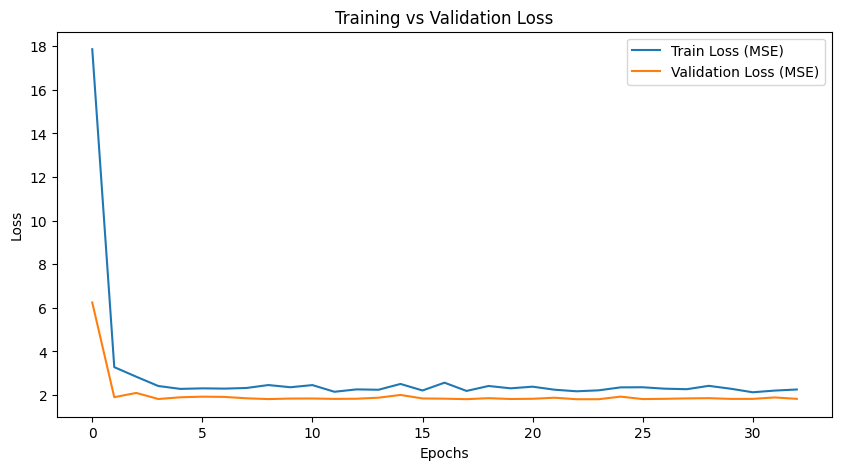

✅ Test MSE: 1.8073, Test MAE: 1.0605
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 653ms/step


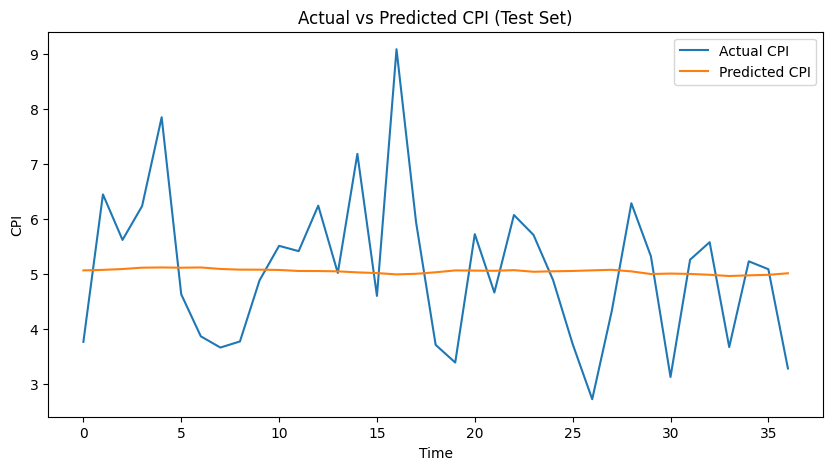

In [6]:
# 6 Training & Evaluation

early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Train Loss (MSE)")
plt.plot(history.history["val_loss"], label="Validation Loss (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

y_pred = model.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual CPI")
plt.plot(y_pred, label="Predicted CPI")
plt.xlabel("Time")
plt.ylabel("CPI")
plt.legend()
plt.title("Actual vs Predicted CPI (Test Set)")
plt.show()

In [7]:
# 7 Fine-tuned GRU Model
# from tensorflow.keras.regularizers import l2
l2 = tf.keras.regularizers.l2

model = Sequential([
    GRU(128, activation="tanh", return_sequences=True,
        kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    GRU(64, activation="tanh", kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss="mse", metrics=["mae"])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 12, 128)        │        61,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,801 (393.75 KB)

 Trainable params: 100,801 (393.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 20.1569 - mae: 4.2421 - val_loss: 11.2774 - val_mae: 3.0416
Epoch 2/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 6.8594 - mae: 2.1314 - val_loss: 2.2288 - val_mae: 1.1366
Epoch 3/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 2.7524 - mae: 1.2802 - val_loss: 2.3874 - val_mae: 1.1644
Epoch 4/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 2.8805 - mae: 1.3447 - val_loss: 2.0252 - val_mae: 1.0590
Epoch 5/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 2.5199 - mae: 1.2803 - val_loss: 2.0613 - val_mae: 1.0788
Epoch 6/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 3.1180 - mae: 1.3458 - val_loss: 2.0210 - val_mae: 1.0670
Epoch 7/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 2.5760 - mae: 1.2571 - val_loss: 2.0183 - val_mae: 1.0668
Epoch 8/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 2.7254 - mae: 1.2991 - val_loss: 2.0304 - val_mae: 1.0713
Epoch 9/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step 

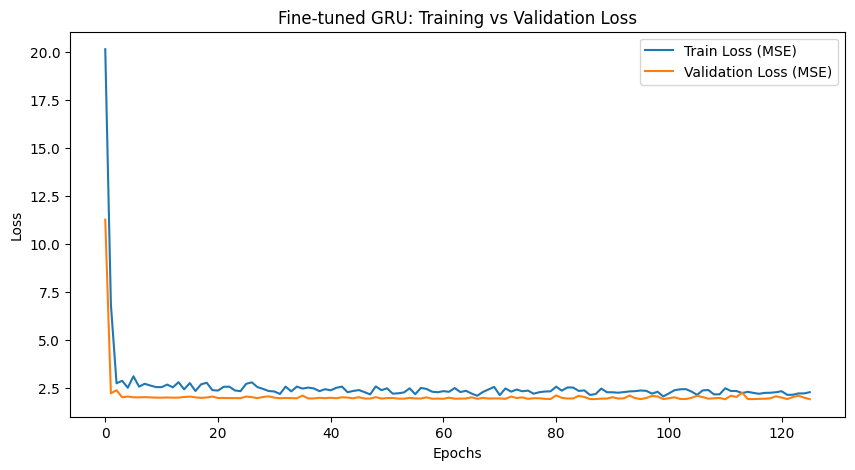

✅ Fine-tuned Test MSE: 1.9213, Test MAE: 1.0559
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 885ms/step


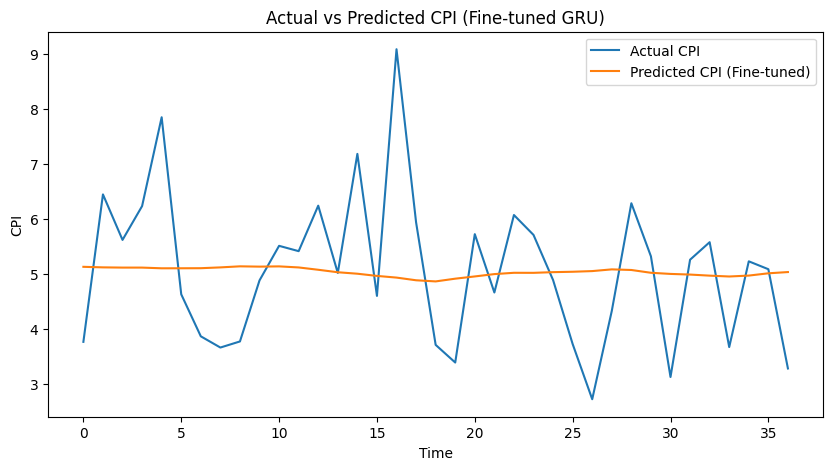

In [8]:
# Retrain Fine-tuned Model

early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

history_ft = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

plt.figure(figsize=(10, 5))
plt.plot(history_ft.history["loss"], label="Train Loss (MSE)")
plt.plot(history_ft.history["val_loss"], label="Validation Loss (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Fine-tuned GRU: Training vs Validation Loss")
plt.show()

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Fine-tuned Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

y_pred_ft = model.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual CPI")
plt.plot(y_pred_ft, label="Predicted CPI (Fine-tuned)")
plt.xlabel("Time")
plt.ylabel("CPI")
plt.legend()
plt.title("Actual vs Predicted CPI (Fine-tuned GRU)")
plt.show()

In [9]:
# 7b Add Seasonal Features + Longer Lags

df_seasonal = df_fe.copy()

df_seasonal["month"] = df_seasonal["Date"].dt.month
df_seasonal["month_sin"] = np.sin(2 * np.pi * df_seasonal["month"] / 12)
df_seasonal["month_cos"] = np.cos(2 * np.pi * df_seasonal["month"] / 12)

for col in ["CPI", "GDP_Growth", "Unemployment_Rate"]:
    df_seasonal[f"{col}_lag6"] = df_seasonal[col].shift(6)
    df_seasonal[f"{col}_lag12"] = df_seasonal[col].shift(12)

df_seasonal = df_seasonal.drop(columns=["month"])

df_seasonal = df_seasonal.dropna().reset_index(drop=True)

print("📊 Added seasonality + deeper lags")
print(df_seasonal.head())


📊 Added seasonality + deeper lags
        Date  CPI  GDP_Growth  Unemployment_Rate  Crude_Oil_Prices  \
0 2008-06-30 5.47        5.53               7.14             80.89   
1 2008-07-31 3.64        5.03               8.42             77.22   
2 2008-08-31 2.88        6.16               7.08             73.36   
3 2008-09-30 7.20       10.63               9.47             58.14   
4 2008-10-31 4.66        2.27               9.11             77.07   

   Gold_Prices  Real_Estate_Index  Stock_Index  Money_Supply_M1  \
0      1677.93             112.74     41394.97            10.81   
1      1516.46             115.19     35823.26            14.59   
2      1713.10             126.36     50725.75            11.52   
3      1396.54             127.84     34062.01            11.61   
4      1781.87             111.39     41549.10            13.22   

   Money_Supply_M2  Industrial_Production  Retail_Sales  Exchange_Rate  \
0             9.74                   3.56          3.99          74.

✅ New sequences ready! Train: (136, 12, 38), Test: (35, 12, 38)


c:\Web development\GRU-RNN_InflationModel\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 228ms/step - loss: 22.0450 - mae: 4.3974 - val_loss: 12.2866 - val_mae: 3.2022
Epoch 2/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 7.1099 - mae: 2.2748 - val_loss: 2.2443 - val_mae: 1.1180
Epoch 3/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 2.8464 - mae: 1.2963 - val_loss: 3.1266 - val_mae: 1.3921
Epoch 4/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 3.2301 - mae: 1.3731 - val_loss: 2.2291 - val_mae: 1.0913
Epoch 5/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 2.8262 - mae: 1.2698 - val_loss: 2.1089 - val_mae: 1.0691
Epoch 6/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2.8633 - mae: 1.3091 - val_loss: 2.1011 - val_mae: 1.0663
Epoch 7/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 3.1054 - mae: 1.3517 - val_loss: 2.0443 - val_mae: 1.0437
Epoch 8/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 2.6612 - mae: 1.1965 - val_loss: 2.0572 - val_mae: 1.0436
Epoch 9/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 2.6377 - m

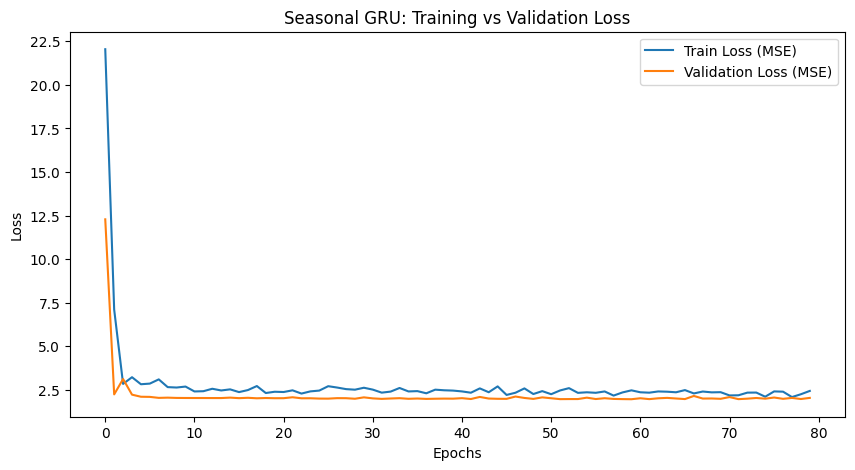

✅ Seasonal Model Test MSE: 1.9670, Test MAE: 1.0305
1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000025518F65F30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 771ms/step


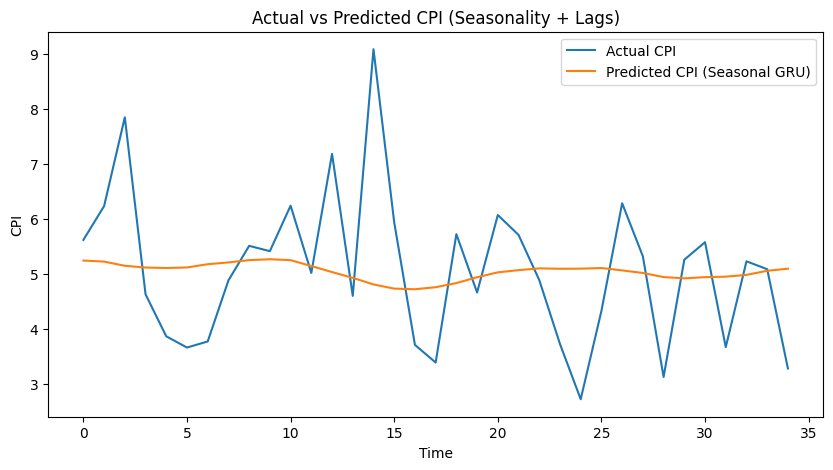

In [10]:
# 8 Retrain with Seasonality + Deeper Lags

features = df_seasonal.drop(columns=["Date"])
target = df_seasonal["CPI"]

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 12
X_seq, y_seq = create_sequences(features_scaled, target, TIME_STEPS)

train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print(f"✅ New sequences ready! Train: {X_train.shape}, Test: {X_test.shape}")

# from tensorflow.keras.regularizers import l2
l2 = tf.keras.regularizers.l2

model = Sequential([
    GRU(128, activation="tanh", return_sequences=True,
        kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    GRU(64, activation="tanh", kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss="mse", metrics=["mae"])

early_stop = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

history_seasonal = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

plt.figure(figsize=(10, 5))
plt.plot(history_seasonal.history["loss"], label="Train Loss (MSE)")
plt.plot(history_seasonal.history["val_loss"], label="Validation Loss (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Seasonal GRU: Training vs Validation Loss")
plt.show()

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Seasonal Model Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

y_pred_seasonal = model.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual CPI")
plt.plot(y_pred_seasonal, label="Predicted CPI (Seasonal GRU)")
plt.xlabel("Time")
plt.ylabel("CPI")
plt.legend()
plt.title("Actual vs Predicted CPI (Seasonality + Lags)")
plt.show()


In [11]:
model.save("inflation_gru_model.h5")
